### Preprocessing

In [1]:
import pandas as np
import pickle
df = np.read_csv('mbti_1.csv')

# populating types array
labels = []
for _type in df['type']:
     labels.append(_type)

with open('processed_posts.pkl', 'rb') as pf:
    posts = pickle.load(pf)

In [2]:
countedPosts = [len(post) for post in posts]

In [3]:
labelsByPost = []
postsByPost = []

for i in range(0, len(posts)):
    for post in posts[i]:
        labelsByPost.append(labels[i])
        postsByPost.append(post)

In [4]:
# Tokenizing data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_features = 10000
max_len = 25
batch_size = 32
max_words = 10000

Using TensorFlow backend.


In [5]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(postsByPost)
sequences = tokenizer.texts_to_sequences(postsByPost)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 75302 unique tokens


In [6]:
data = sequence.pad_sequences(sequences, maxlen=max_len)
label_dictionary = {
    'I': 0,
    'E': 1
}

labels = [label_dictionary[label[0]] for label in labelsByPost]

In [18]:
import numpy as np
labels = np.asarray(labels).astype('float32')

In [95]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (383869, 25)
Shape of label tensor: (383869,)


In [96]:
# Separating the test labels and test data
# from the rest, so we can keep track of users accordingly
# Getting the first 800 users for testing
# Getting users 800-1000 for validating
testUsers = 35431
valUsers = 8901

x_test = data[:35431]
y_test = labels[:35431]

x_val = data[35431:35431+8901]
y_val = labels[35431:35431+8901]

data = data[35431+8901:]
labels = labels[35431+8901:]

In [8]:
test_boundaries = countedPosts[:800]
val_boundaries = countedPosts[800:1000]

In [9]:
e_labels = []
e_data = []
i_labels = []
i_data = []

for i in range(0, len(labels)):
    if (labels[i] == 0):
        i_labels.append(labels[i])
        i_data.append(data[i])
    if (labels[i] == 1):
        e_labels.append(labels[i])
        e_data.append(data[i])

In [10]:
mix_labels = e_labels + i_labels[:len(e_labels)]
mix_data = e_data + i_data[:len(e_data)]

In [20]:
mix_labels = np.asarray(mix_labels).astype('float32')
mix_data = np.array(mix_data).astype('float32')

In [23]:
indices = np.arange(mix_data.shape[0])
np.random.shuffle(indices)
mix_data = mix_data[indices]
mix_labels = mix_labels[indices]

In [26]:
partial_x_train = mix_data[:80000]
partial_y_train = mix_labels[:80000]

x_train = mix_data
y_train = mix_labels

In [28]:
from keras.callbacks import Callback

class True_eval(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.i_accuracy = []
        self.e_accuracy = []
        self.user_accuracy = []
    
    def ie_real_acc(self, prediction):
        y_true = self.validation_data[1]
        i_acc = 0
        i_total = 0
        e_acc = 0
        e_total = 0
        for i in range(0, len(prediction)):
            if (y_true[i] == 0):
                if (prediction[i].round() == y_true[i]):
                    i_acc += 1
                i_total += 1
            else:
                if (prediction[i].round() == y_true[i]):
                    e_acc += 1
                e_total += 1
        return (i_acc/i_total), (e_acc/e_total)
    
    def user_acc(self, prediction):
        y_true = self.validation_data[1]
        usersCorrect = []
        start = 0
        for length in countedPosts:
            correct = 0
            for i in range(0, length):
                if (y_true[i+start] == prediction[i+start]):
                    correct += 1
            usersCorrect.append(round(correct/length))
            start +=length
            
        return sum(usersCorrect)/len(usersCorrect)
                
        
    
    def on_epoch_end(self, epoch, logs={}):
        x_val = self.validation_data[0]
        y_pred = self.model.predict(x_val)
        i_real_acc, e_real_acc = self.ie_real_acc(y_pred)
        user_acc = user_acc(y_pred)
        print ("I Acc: %f" % i_real_acc)
        print ("E Acc: %f" % e_real_acc)
        print ("User Acc: %f" % user_acc)
        self.i_accuracy.append(i_real_acc)
        self.e_accuracy.append(e_real_acc)
        self.user_accuracy.append(user_acc)

In [81]:
from keras import models
from keras import layers
from keras.regularizers import l1_l2
from keras.layers import Embedding, Dropout, LSTM, Dense

def build_model():
    model = models.Sequential()
    model.add(Embedding(max_features, 128, input_length=max_len))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    #model.layers[0].set_weights([embedding_matrix])
    #model.layers[0].trainable = False

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [84]:
import tensorflow as tf
model = build_model()
with tf.device('/gpu:0'):
    true_metrics = True_eval((x_val, y_val))
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(x_val, y_val),
                        epochs=100, batch_size=256, 
                        callbacks=[true_metrics])

Train on 160000 samples, validate on 8901 samples
Epoch 1/100
 62976/160000 [==========>...................] - ETA: 33s - loss: 0.6910 - acc: 0.5228

KeyboardInterrupt: 

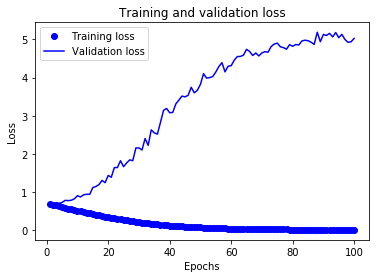

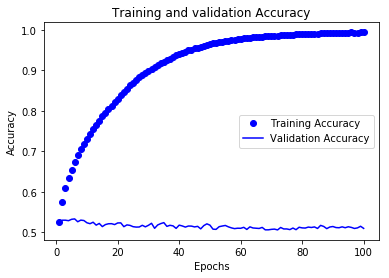

<Figure size 432x288 with 0 Axes>

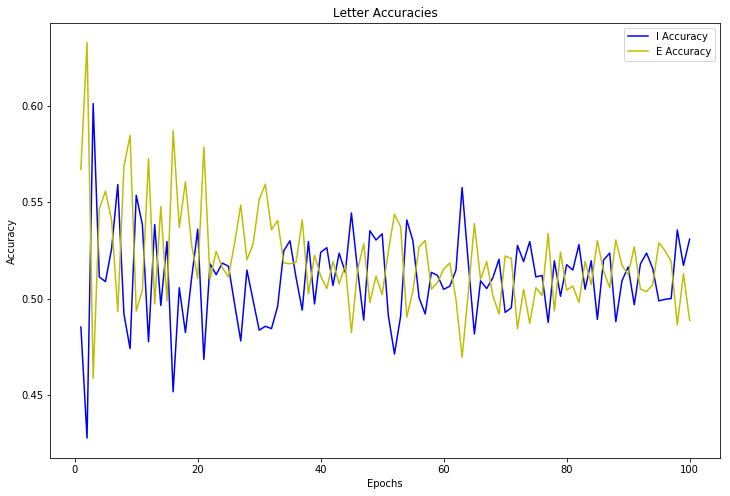

In [41]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['categorical_accuracy']
val_acc   = history_dict['val_categorical_accuracy']

epochs = range(1, len(history_dict['categorical_accuracy']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(12,8))
plt.plot(epochs, true_metrics.i_accuracy, 'b', label='I Accuracy')
plt.plot(epochs, true_metrics.e_accuracy, 'y', label='E Accuracy')
plt.title('Letter Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()